In [1]:
#Importing required libraries
import cv2
import torch
import numpy as np
import torch.nn as nn
import tensorflow as tf
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from keras.datasets import mnist

#Initializing device details and Importing the dataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
(xTrain, yTrain), (xTest, yTest) = mnist.load_data()

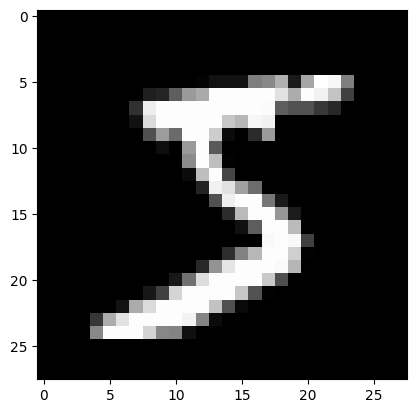

In [2]:
plt.imshow(xTrain[0]/27, cmap = 'gray')

In [3]:
#Dataset Preprocessing
length, breadth = xTrain[0].shape
flattenDim = length * breadth
#xTrain = torch.FloatTensor(np.round(xTrain / 27).astype(int)).to(device)
xTrain = np.round(xTrain / 27).astype(int)
xTest = np.round(xTest / 27).astype(int)
xTrainFlat = torch.FloatTensor(np.reshape(xTrain, (-1,flattenDim))).to(device)
xTestFlat = np.reshape(xTest, (-1,flattenDim)) 

In [4]:
#Dataloader
trainLoader = DataLoader(dataset = xTrainFlat, batch_size = 100, shuffle = True)

In [5]:
#Autoencoder NN Module consisting of Encoder and Decoder classes
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.Encoder = nn.Sequential(
        nn.Linear(in_features = 784, out_features = 500),
        nn.ReLU(),
        nn.Linear(in_features = 500, out_features = 250),
        nn.ReLU(),
        nn.Linear(in_features = 250, out_features = 100),
        nn.ReLU(),
        nn.Linear(in_features = 100, out_features = 50),
        nn.ReLU(),
        nn.Linear(in_features = 50, out_features = 25),
        nn.ReLU(),
        nn.Linear(in_features = 25, out_features = 9),
        nn.ReLU()

        )
        self.Decoder = nn.Sequential(
        nn.Linear(in_features = 9, out_features = 25),
        nn.ReLU(),
        nn.Linear(in_features = 25, out_features = 50),
        nn.ReLU(),
        nn.Linear(in_features = 50, out_features = 100),
        nn.ReLU(),
        nn.Linear(in_features = 100, out_features = 250),
        nn.ReLU(),
        nn.Linear(in_features = 250, out_features = 500),
        nn.ReLU(),
        nn.Linear(in_features = 500, out_features = 784),
        nn.ReLU()
        )
        
    def forward(self, output):
        output = self.Encoder(output)
        output = self.Decoder(output)
        return output

Epoch:  0 | Average loss:  7.512 | Lowest Loss:  5.933
Epoch:  1 | Average loss:  6.349 | Lowest Loss:  5.852
Epoch:  2 | Average loss:  6.298 | Lowest Loss:  5.722
Epoch:  3 | Average loss:  6.187 | Lowest Loss:  5.563
Epoch:  4 | Average loss:  5.46 | Lowest Loss:  4.835
Epoch:  5 | Average loss:  5.084 | Lowest Loss:  4.445
Epoch:  6 | Average loss:  4.837 | Lowest Loss:  4.294
Epoch:  7 | Average loss:  4.716 | Lowest Loss:  4.218
Epoch:  8 | Average loss:  4.564 | Lowest Loss:  4.131
Epoch:  9 | Average loss:  4.41 | Lowest Loss:  3.939
Epoch:  10 | Average loss:  4.26 | Lowest Loss:  3.799
Epoch:  11 | Average loss:  4.146 | Lowest Loss:  3.576
Epoch:  12 | Average loss:  4.06 | Lowest Loss:  3.509
Epoch:  13 | Average loss:  3.991 | Lowest Loss:  3.461
Epoch:  14 | Average loss:  3.904 | Lowest Loss:  3.416
Epoch:  15 | Average loss:  3.893 | Lowest Loss:  3.375
Epoch:  16 | Average loss:  3.859 | Lowest Loss:  3.382
Epoch:  17 | Average loss:  3.799 | Lowest Loss:  3.235
Epoch:

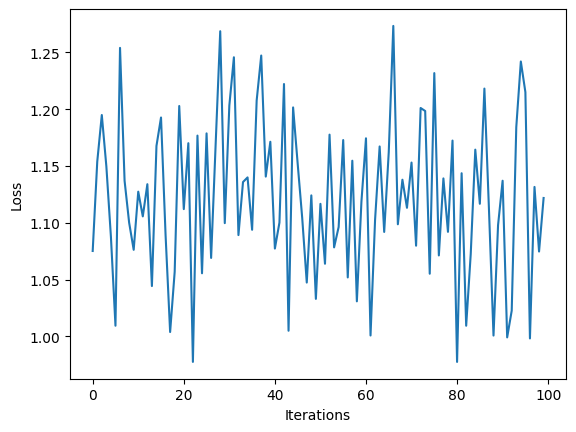

In [6]:
model = autoencoder().to(device)
modelParameters = list(model.parameters())
criterion = nn.MSELoss(reduction = 'mean')
optimizer = optim.SGD(modelParameters, lr = (1e-2), momentum = 0.8)

encoderOutputs = []
decoderOutputs = []
for epoch in range(300):
  losses = []
  for batchIndex, batchImage in enumerate(trainLoader):
    batchImage = batchImage.to(device)
    batchImage = batchImage.unsqueeze(1)
    reconstructedImage = model(batchImage)
    loss = criterion(reconstructedImage, batchImage)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.cpu().detach().numpy())
    #encoderOutputs.append((epoch, batchIndex, encoderOutput.detach()))
    #WhatdecoderOutputs.append((epoch, batchIndex, decoderOutput))
  print("Epoch: ",epoch,"| Average loss: ",np.round(np.average(losses), 3),"| Lowest Loss: ",np.round(np.amin(losses), 3))
  torch.save(model.state_dict(), "AE.pth")

In [13]:
output = model(torch.FloatTensor(xTestFlat[438]/27).unsqueeze(0).to(device))

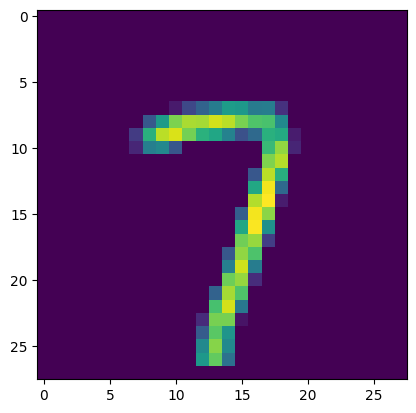

In [14]:
plt.imshow(output.cpu().detach().numpy().reshape(28, 28))

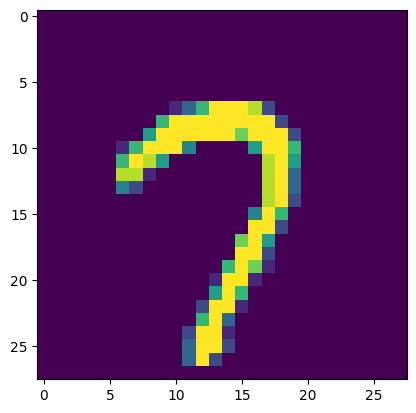

In [15]:
plt.imshow(xTest[438]/27)